In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.optimize as spo
import scipy.signal as sps
from pathlib import Path

from spectrometer import FID1D, plot, process

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
file = Path("../data/20230719-160040-Water_1H_andrew_probe_9us_pulse_25us_delay.fid")
fid = FID1D.from_file(file)

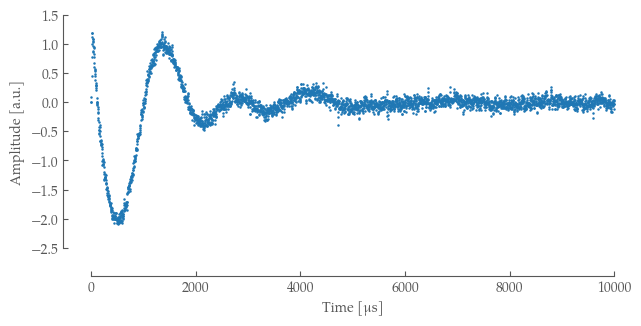

In [3]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    fid.us_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [μs]")

plot.format_for_thesis(axes)

fig.savefig("fid_raw.pdf")

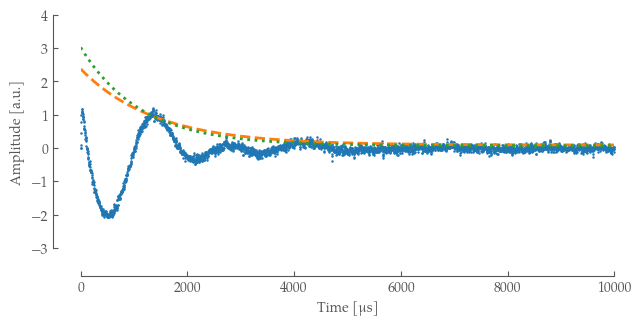

In [4]:
# Try to plot simple least squares fit
# Try fitting the envelope
envelope = np.abs(sps.hilbert(fid.data.real))
fit_lorentz = process.fit_exp_decay(fid.us_scale, envelope)
hz_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
    linewidth=2,
)

# Try fitting the absolute directly
fit_abs = process.fit_exp_decay(fid.us_scale, np.abs(fid.data))
axes.plot(
    hz_scale_fine,
    fit_abs["function"](hz_scale_fine),
    linestyle=":",
    linewidth=2,
)

fig.savefig("fid_fit.pdf")
fig

/home/max/Projects/nmr-spectrometer/software/spectrometer/.venv/lib64/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


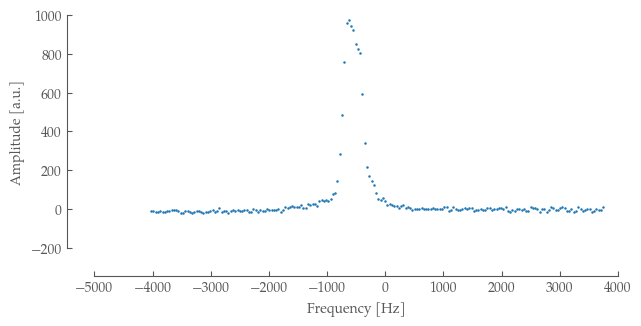

In [5]:
# Fourier Transform
hz_scale, fft_vals = fid.simple_fft(phase_shift_kwargs={"p0": 68, "p1": 0})
peak_hz_scale = hz_scale[4000:4200]
peak_fft_vals = fft_vals[4000:4200]

# Plot Fourier Transform
cm = 1 / 2.54
fig, axes = plt.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    layout="constrained",
)
axes.plot(
    peak_hz_scale,
    peak_fft_vals,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_for_thesis(axes)

fig.savefig("fft_raw.pdf")

/home/max/Projects/nmr-spectrometer/software/spectrometer/spectrometer/process.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  y = np.asarray(y, dtype=np.float64)


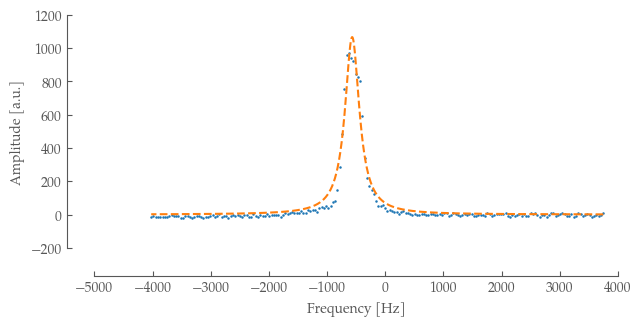

In [7]:
# Try to plot simple least squares fit for a lorentzian peak
fit_lorentz = process.fit_lorentz(peak_hz_scale, peak_fft_vals)
hz_scale_fine = np.linspace(peak_hz_scale[0], peak_hz_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
)

fig.savefig("fft_fit.pdf")
fig